In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pygtc
import batman
import scipy
import logging
from matplotlib import gridspec
%matplotlib widget

logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
def log_likelihood(theta):

    params = batman.TransitParams()
    params.t0 =  theta[0]                
    params.per = theta[1]                    
    params.rp =  theta[2]                 
    params.a =   theta[3]                   
    params.inc =  theta[4]    
    params.ecc = 0.
    params.w = 90. 
    params.u = [theta[5] , theta[6]]
    params.limb_dark = "quadratic"

    chi2_tess = []
    sum_ln_sigma_tess = []

    for i in range(0, 4):
        m_tess = batman.TransitModel(params, bjd_tess[i])
        tess_model = m_tess.light_curve(params)
        tess_errors_with_jitter = flux_error_tess[i]**2 + theta[12]**2
        chi2_tess = np.append(np.sum((flux_tess[i]-tess_model)**2 / tess_errors_with_jitter), chi2_tess)
        sum_ln_sigma_tess = np.append(np.sum(np.log(tess_errors_with_jitter)), sum_ln_sigma_tess)

    params.u = [theta[7] , theta[8]]

    median_bjd = np.median(bjd_taste)
    polynomial_trend = theta[9]+theta[10]*(bjd_taste-median_bjd) + theta[11]*(bjd_taste-median_bjd)**2
    
    m_taste = batman.TransitModel(params, bjd_taste)
    taste_flux = m_taste.light_curve(params) * polynomial_trend

    taste_errors_with_jitter = flux_error_taste**2 + theta[13]**2

    N = len(tess_errors_with_jitter) + len(taste_errors_with_jitter)

    chi2_taste = np.sum((flux_taste-taste_flux)**2 / taste_errors_with_jitter)

    sum_ln_sigma_taste = np.sum(np.log(taste_errors_with_jitter))

    log_likelihood = -0.5 * ( N * np.log(2*np.pi) + chi2_tess[0] + chi2_tess[1] + chi2_tess[2] + chi2_tess[3] + chi2_taste + 
                             sum_ln_sigma_tess[0] + sum_ln_sigma_tess[1] + sum_ln_sigma_tess[2] + sum_ln_sigma_tess[3] + sum_ln_sigma_taste)
    return log_likelihood

def log_prior(theta):
    prior = 0.00
    prior+= np.log(scipy.stats.norm.pdf(theta[5], loc=0.5011, scale=0.10))
    prior+= np.log(scipy.stats.norm.pdf(theta[6], loc=0.1396, scale=0.10))
    prior+= np.log(scipy.stats.norm.pdf(theta[7], loc=0.6367, scale=0.10))
    prior+= np.log(scipy.stats.norm.pdf(theta[8], loc=0.1300, scale=0.10))
    return prior

def log_posterior(theta):

    boundaries = np.empty([2, len(theta)])

    boundaries[:,0] = [theta[0]-0.5, theta[0]+0.5]
    boundaries[:,1] = [theta[1]-0.5, theta[1]+0.5]
    boundaries[:,2] = [0.0, 0.5]
    boundaries[:,3] = [0.0, 20.]
    boundaries[:,4] = [80.0, 90.0]
    boundaries[:,5] = [0.00, 1.0]
    boundaries[:,6] = [0.00, 1.0]
    boundaries[:,7] = [0.00, 1.0]
    boundaries[:,8] = [0.00, 1.0]
    boundaries[:,9] = [0.0, 1.0]
    boundaries[:,10] = [-1.0, 1.0]
    boundaries[:,11] = [-1.0, 1.0]
    boundaries[:,12] = [0.0, 0.05]
    boundaries[:,13] = [0.0, 0.05]
    
    sel = (theta < boundaries[0,:]) | (theta >   boundaries[1,:])
    if np.sum(sel) > 0:
        return -np.inf
    
    log_post = log_prior(theta)

    log_post += log_likelihood(theta)
    return log_post

In [10]:
#values from literature

hartman = [3.2130598, 0.1406, 11.77, 89.0]
hartman_err = [0.0000021, 0.0013, 0.18, 0.4]

patel = [3.2130598, 0.1387, 11.24, 0.00]
patel_err = [0.0000019 , 0.0028, 0.47, 0.00]

ozturk = [3.2130579, 0.139, 11.364, 88.24]
ozturk_err = [0.0000004, 0.006, 0.648, 0.60]

def compatibility_test(result, result_err, literature, literature_err):
    s = np.abs(literature - result) / np.sqrt(literature_err**2 + result_err**2)
    return s

In [11]:
#import the results of MCMCs

taste = pickle.load(open('../Results/MCMC/TASTE/run_taste_v6.p', 'rb'))
mcmc_taste = np.empty(14)
mcmc_taste_err = np.empty_like(mcmc_taste)

tess = pickle.load(open('../Results/MCMC/TESS/run_alltess_v3.p', 'rb'))
mcmc_tess_all = np.empty(8)
mcmc_tess_all_err = np.empty_like(mcmc_tess_all)

tess_s23 = pickle.load(open('../Results/MCMC/TESS/run23_tess_v5.p', 'rb'))
mcmc_tess_s23 = np.empty(8)
tess_s49 = pickle.load(open('../Results/MCMC/TESS/run49_tess_v5.p', 'rb'))
mcmc_tess_s49 = np.empty(8)
tess_s50 = pickle.load(open('../Results/MCMC/TESS/run50_tess_v5.p', 'rb'))
mcmc_tess_s50 = np.empty(8)
tess_s76 = pickle.load(open('../Results/MCMC/TESS/run76_tess_v5.p', 'rb'))
mcmc_tess_s76 = np.empty(8)

taste_tess = pickle.load(open('../Results/MCMC/taste_tess(t)_v4.p', 'rb'))
mcmc_taste_tess = np.empty(14)
mcmc_taste_tess_err = np.empty_like(mcmc_taste_tess)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

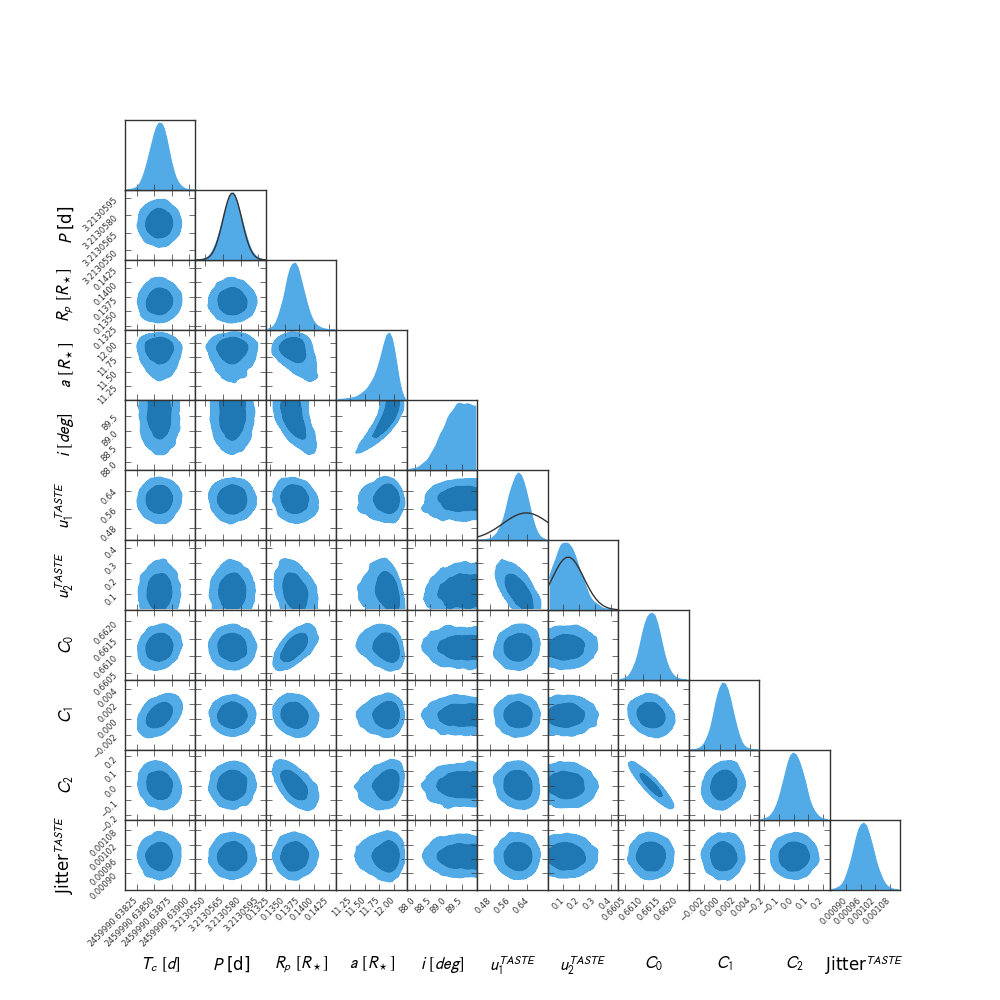

In [12]:
paramnames = ('$T_c$ $[d]$',
         '$P$ [d]',
         '$R_p$ $[R_\star]$',
         '$a$ $[R_\star]$',
         '$i$ $[deg]$',
         '$u_1^{TASTE}$',
         '$u_2^{TASTE}$',
         '$C_0$',
         '$C_1$',
         '$C_2$',
         'Jitter$^{TASTE}$')

priors = (None, (3.2130573, 0.0000008),
          None, None, None,
          (0.6367, 0.1),
          (0.1300, 0.1), 
          None, None, None, None)
flat_sample_taste = taste.get_chain(discard=5000, thin=100, flat=True)
GTC = pygtc.plotGTC(chains=flat_sample_taste, paramNames=paramnames, priors=priors, plotName = './Plots/mcmc_taste.png',
                    figureSize = 10, customLabelFont={'size':12})

ndim = 11

from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_sample_taste[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))
    
    mcmc_taste[i] = mcmc[1]
    mcmc_taste_err[i] = (np.abs(q[0]) + q[1])/2

#np.savetxt('../Results/MCMC_TASTE.txt', np.c_[mcmc_taste], fmt='%.8f', delimiter=' & ', newline=' \\\\\n')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

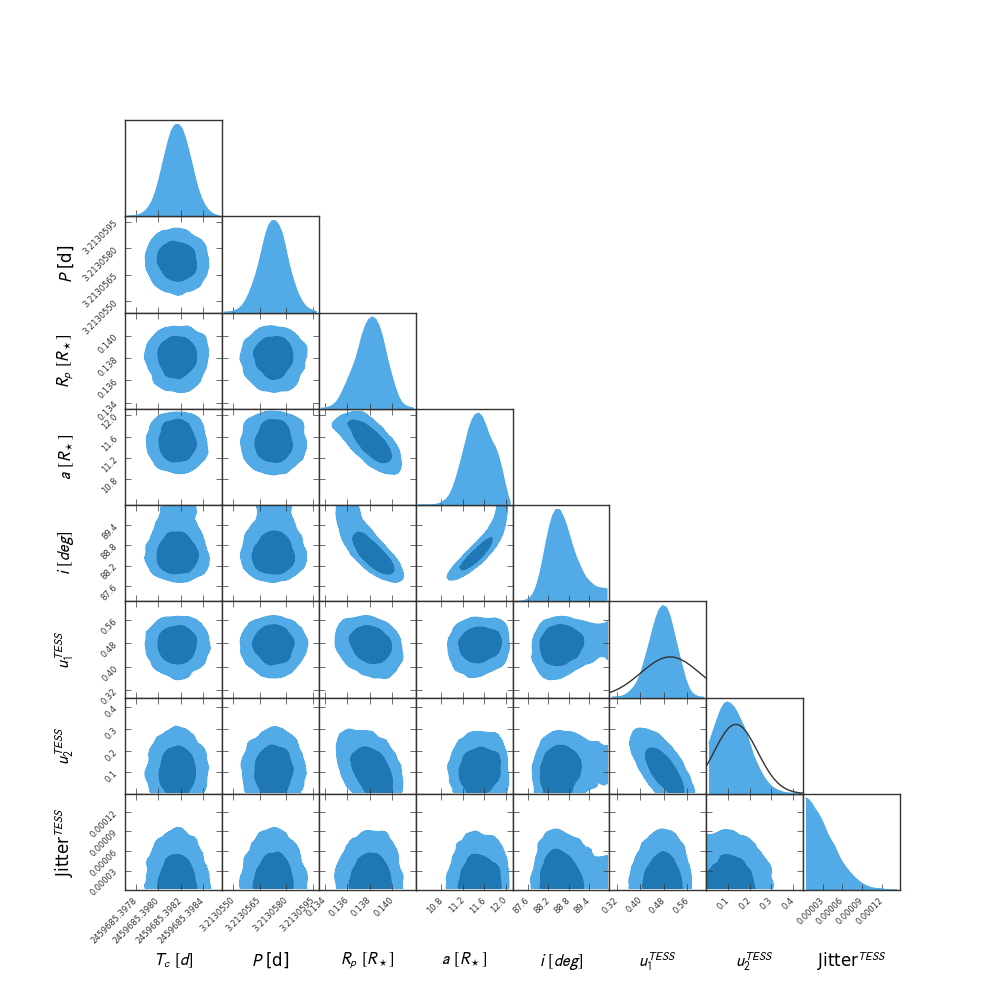

In [13]:
paramnames = ('$T_c$ $[d]$',
         '$P$ [d]',
         '$R_p$ $[R_\star]$',
         '$a$ $[R_\star]$',
         '$i$ $[deg]$',
         '$u_1^{TESS}$',
         '$u_2^{TESS}$',
         'Jitter$^{TESS}$')

priors = (None, None, None, None, None, 
          (0.5019, 0.1), (0.1364, 0.1), None)

flat_sample_tessall = tess.get_chain(discard=5000, thin=100, flat=True)
GTC = pygtc.plotGTC(chains=flat_sample_tessall, paramNames=paramnames, priors=priors, plotName='./Plots/mcmc_tessall.png',
                    figureSize = 10, customLabelFont={'size':12})

ndim = 8

from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_sample_tessall[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.9f}_{{-{1:.9f}}}^{{{2:.9f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))
    
    mcmc_tess_all[i] = mcmc[1]
    mcmc_tess_all_err[i] = (np.abs(q[0]) + q[1])/2

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

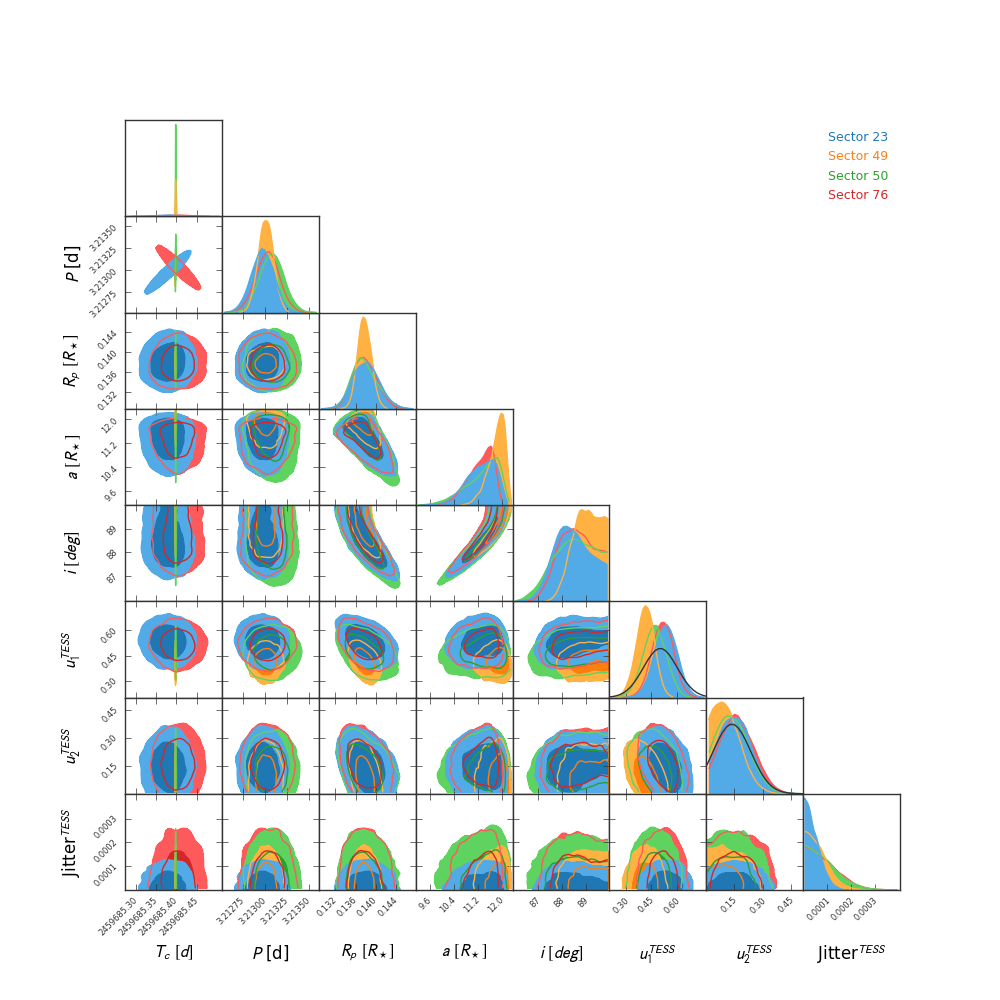

In [14]:
paramnames = ('$T_c$ $[d]$',
         '$P$ [d]',
         '$R_p$ $[R_\star]$',
         '$a$ $[R_\star]$',
         '$i$ $[deg]$',
         '$u_1^{TESS}$',
         '$u_2^{TESS}$',
         'Jitter$^{TESS}$')

flat_sample23 = tess_s23.get_chain(discard=5000, thin=100, flat=True)
flat_sample49 = tess_s49.get_chain(discard=5000, thin=100, flat=True)
flat_sample50 = tess_s50.get_chain(discard=5000, thin=100, flat=True)
flat_sample76 = tess_s76.get_chain(discard=5000, thin=100, flat=True)

flat_tess_individual = [flat_sample23, flat_sample49, flat_sample50, flat_sample76]
mcmc_tess_individual = [mcmc_tess_s23, mcmc_tess_s49, mcmc_tess_s50, mcmc_tess_s76]

chainlabels = ('Sector 23', 'Sector 49', 'Sector 50', 'Sector 76')
priors = priors = (None, None, None, None, None, 
                   (0.5019, 0.1), (0.1364, 0.1), None)

GTC = pygtc.plotGTC(chains=[flat_sample23, flat_sample49, flat_sample50, flat_sample76], 
                    paramNames=paramnames, chainLabels=chainlabels, priors=priors, plotName='./Plots/mcmc_tessind.png',
                    figureSize = 10, customLabelFont={'size':12})

ndim = 8

from IPython.display import display, Math
for j in range(4):
    flat_sample_tess = flat_tess_individual[j]
    mcmc_tess = mcmc_tess_individual[j]
    for i in range(ndim):
        mcmc = np.percentile(flat_sample_tess[:, i], [15.865, 50, 84.135])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], i)
        display(Math(txt))
        mcmc_tess[i] = mcmc[1]
    print()    

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

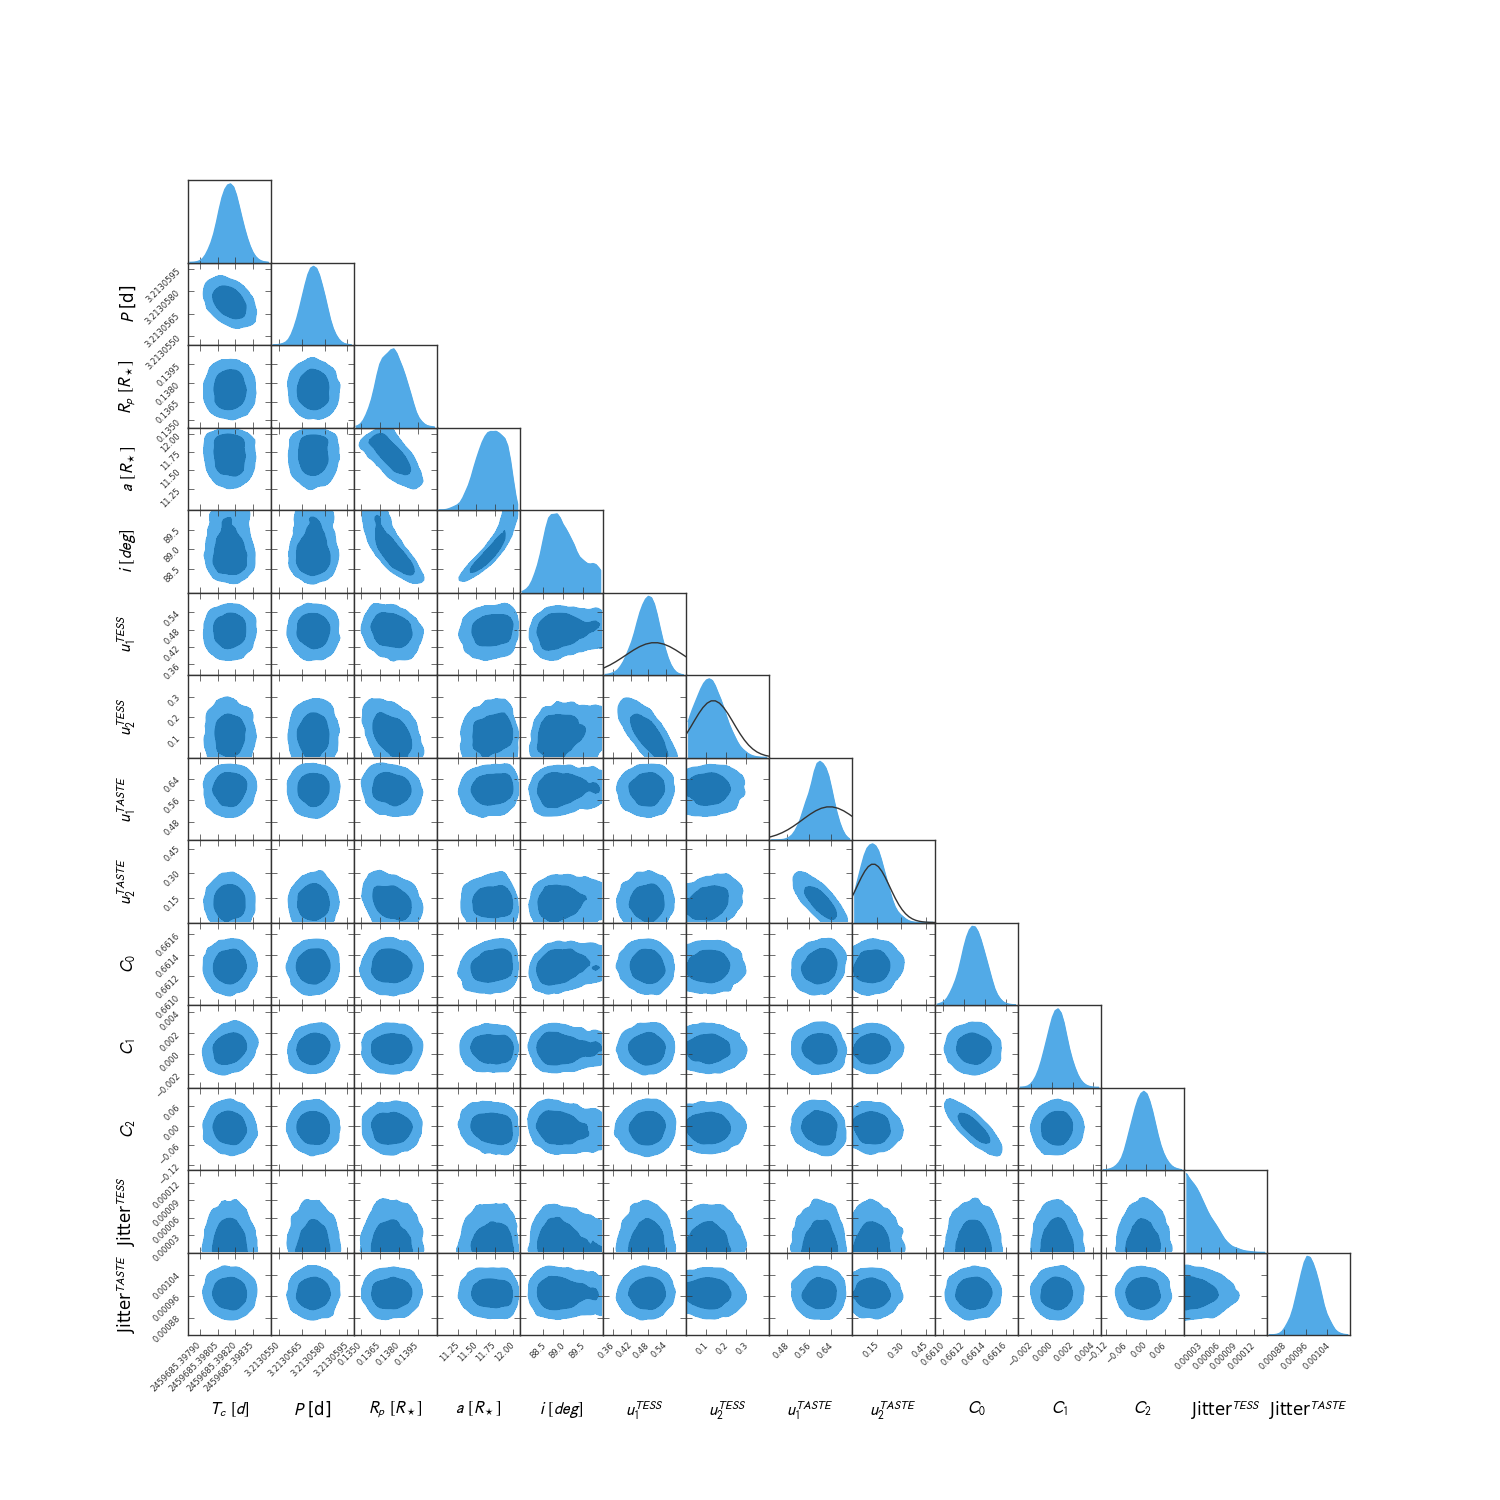

In [15]:
paramnames = ('$T_c$ $[d]$',
         '$P$ [d]',
         '$R_p$ $[R_\star]$',
         '$a$ $[R_\star]$',
         '$i$ $[deg]$',
         '$u_1^{TESS}$',
         '$u_2^{TESS}$',
         '$u_1^{TASTE}$',
         '$u_2^{TASTE}$',
         '$C_0$',
         '$C_1$',
         '$C_2$',
         'Jitter$^{TESS}$',
         'Jitter$^{TASTE}$')

priors = (None, None, None, None, None,
          (0.5019, 0.1),
          (0.1364, 0.1),
          (0.6367, 0.1),
          (0.1300, 0.1),
          None, None, None, None, None)

flat_sample_taste_tess = taste_tess.get_chain(discard=5000, thin=100, flat=True)
GTC = pygtc.plotGTC(chains=flat_sample_taste_tess, paramNames=paramnames, priors=priors, plotName='./Plots/mcmc_tastetess(t).png',
                    figureSize = 15, customLabelFont={'size':12})

ndim = 14

for i in range(ndim):
    mcmc = np.percentile(flat_sample_taste_tess[:, i], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))
    
    mcmc_taste_tess[i] = mcmc[1]
    mcmc_taste_tess_err[i] = (np.abs(q[0]) + q[1])/2

In [16]:
for i in range(4):
    mcmc = np.percentile(flat_sample_taste[:, i+1], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))

    print('Compatibility with Hartman09:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, hartman[i], hartman_err[i]))
    print('Compatibility with Patel22:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, patel[i], patel_err[i]))
    print('Compatibility with Ozturk19:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, ozturk[i], ozturk_err[i]))

<IPython.core.display.Math object>

Compatibility with Hartman09: 1.1150878557034456
Compatibility with Patel22: 1.2153827266133772
Compatibility with Ozturk19: 0.6765129526825444


<IPython.core.display.Math object>

Compatibility with Hartman09: 1.9564547157212473
Compatibility with Patel22: 0.6236195847824125
Compatibility with Ozturk19: 0.3687306354657076


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.4317044903223535
Compatibility with Patel22: 1.2771054692683934
Compatibility with Ozturk19: 0.7639184165861053


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.6297198674038978
Compatibility with Patel22: 193.13723520120496
Compatibility with Ozturk19: 1.511318307023845


In [17]:
for i in range(4):
    mcmc = np.percentile(flat_sample_tessall[:, i+1], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))

    print('Compatibility with Hartman09:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, hartman[i], hartman_err[i]))
    print('Compatibility with Patel22:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, patel[i], patel_err[i]))
    print('Compatibility with Ozturk19:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, ozturk[i], ozturk_err[i]))

<IPython.core.display.Math object>

Compatibility with Hartman09: 1.1297842776230056
Compatibility with Patel22: 1.2336354045843834
Compatibility with Ozturk19: 0.7311613810082598


<IPython.core.display.Math object>

Compatibility with Hartman09: 1.3818247668014039
Compatibility with Patel22: 0.1952519671478414
Compatibility with Ozturk19: 0.14669798028612047


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.8432940447395938
Compatibility with Patel22: 0.4783183152954305
Compatibility with Ozturk19: 0.19195961566287267


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.6986345829688438
Compatibility with Patel22: 193.23207343783108
Compatibility with Ozturk19: 0.4436317247631498


In [18]:
for i in range(4):
    mcmc = np.percentile(flat_sample_taste_tess[:, i+1], [15.865, 50, 84.135])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], i)
    display(Math(txt))

    print('Compatibility with Hartman09:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, hartman[i], hartman_err[i]))
    print('Compatibility with Patel22:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, patel[i], patel_err[i]))
    print('Compatibility with Ozturk19:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, ozturk[i], ozturk_err[i]))

<IPython.core.display.Math object>

Compatibility with Hartman09: 1.1474573560637915
Compatibility with Patel22: 1.2541572792742388
Compatibility with Ozturk19: 0.7908377282641661


<IPython.core.display.Math object>

Compatibility with Hartman09: 1.8901616412889943
Compatibility with Patel22: 0.42209259621739553
Compatibility with Ozturk19: 0.25653288365782606


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.2313230189039628
Compatibility with Patel22: 0.9217963776594761
Compatibility with Ozturk19: 0.5096451735535585


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.0979601572308908
Compatibility with Patel22: 189.63447584613778
Compatibility with Ozturk19: 0.9186675873173986


In [19]:
for j in range(4):
    flat_sample_tess = flat_tess_individual[j]
    mcmc_tess = mcmc_tess_individual[j]
    for i in range(4):
        mcmc = np.percentile(flat_sample_tess[:, i+1], [15.865, 50, 84.135])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], i)
        display(Math(txt))

        print('Compatibility with Hartman09:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, hartman[i], hartman_err[i]))
        print('Compatibility with Patel22:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, patel[i], patel_err[i]))
        print('Compatibility with Ozturk19:', compatibility_test(mcmc[1], (np.abs(q[0]) + q[1])/2, ozturk[i], ozturk_err[i]))
    print('########################################################') 

<IPython.core.display.Math object>

Compatibility with Hartman09: 0.677122244215565
Compatibility with Patel22: 0.6771397307737903
Compatibility with Ozturk19: 0.6619467612291252


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.9018438282724888
Compatibility with Patel22: 0.17910116943803547
Compatibility with Ozturk19: 0.15001528138674267


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.8002912809440459
Compatibility with Patel22: 0.16751015473030334
Compatibility with Ozturk19: 0.012908144510635796


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.6001708136171516
Compatibility with Patel22: 106.28859725910549
Compatibility with Ozturk19: 0.2006817980731718
########################################################


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.5784513761519416
Compatibility with Patel22: 0.5784849273125486
Compatibility with Ozturk19: 0.5557442624592734


<IPython.core.display.Math object>

Compatibility with Hartman09: 1.5702439725879969
Compatibility with Patel22: 0.32299682849131545
Compatibility with Ozturk19: 0.21143984554014236


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.29130227782770696
Compatibility with Patel22: 1.149398017462733
Compatibility with Ozturk19: 0.7127875226818442


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.12261391758184177
Compatibility with Patel22: 144.24293232969984
Compatibility with Ozturk19: 0.9873809562592383
########################################################


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.15065932411012725
Compatibility with Patel22: 0.15066294565754387
Compatibility with Ozturk19: 0.16540916266610067


<IPython.core.display.Math object>

Compatibility with Hartman09: 1.07179578428606
Compatibility with Patel22: 0.30003691679415556
Compatibility with Ozturk19: 0.21956619214877893


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.5017249794495813
Compatibility with Patel22: 0.3163784677426541
Compatibility with Ozturk19: 0.12621474755989118


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.41968301390509294
Compatibility with Patel22: 94.72987674598892
Compatibility with Ozturk19: 0.299913080793971
########################################################


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.21008208531431938
Compatibility with Patel22: 0.21008731139578754
Compatibility with Ozturk19: 0.19512451749737633


<IPython.core.display.Math object>

Compatibility with Hartman09: 1.092487948531932
Compatibility with Patel22: 0.276499041982042
Compatibility with Ozturk19: 0.2029299469982464


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.9019840566217122
Compatibility with Patel22: 0.18137120157465428
Compatibility with Ozturk19: 0.01192159790908468


<IPython.core.display.Math object>

Compatibility with Hartman09: 0.4019485052783408
Compatibility with Patel22: 108.59437836726357
Compatibility with Ozturk19: 0.38958392673749065
########################################################


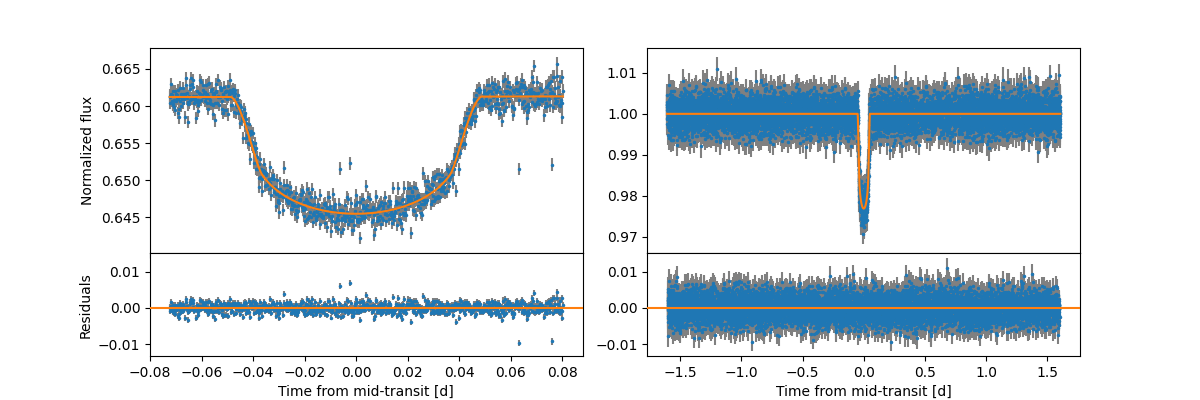

In [20]:
taste_target_dictionary = pickle.load(open('../Results/TASTE/target_dictionary.p', 'rb'))
taste_bjd = taste_target_dictionary['time']
differential_allref = pickle.load(open('../Results/TASTE/differential_allref.p', 'rb'))
differential_allref_err = pickle.load(open('../Results/TASTE/differential_allref_err.p', 'rb'))

tess_sector76_dictionary = pickle.load(open('../Results/TESS/sector76_flatten.p', 'rb'))
tess_bjd = tess_sector76_dictionary['time']
tess_normalized_flux_76 = tess_sector76_dictionary['flux']
tess_normalized_flux_err_76 = tess_sector76_dictionary['flux_error']

transit_time = mcmc_tess_s76[0]
period = mcmc_tess_s76[1]
#transit_duration = 2.169 / 24.

phase_folded_time = (tess_bjd - transit_time - period/2)%period - period/2

taste_bjd = taste_bjd - mcmc_taste[0]     #from MCMC

#overimpose the model with the TASTE and TESS normalized light curves

params_taste = batman.TransitParams()                                                   #object to store transit parameters
params_taste.t0 = 0.0                                                                   #time of inferior conjunction
params_taste.per = mcmc_taste[1]                                                        #orbital period
params_taste.rp = mcmc_taste[2]                                                         #planet radius (in units of stellar radii)
params_taste.a = mcmc_taste[3]                                                          #semi-major axis (in units of stellar radii)
params_taste.inc = mcmc_taste[4]                                                        #orbital inclination (in degrees)
params_taste.ecc = 0.                                                                   #eccentricity
params_taste.w = 90.                                                                    #longitude of periastron (in degrees)
params_taste.limb_dark = "quadratic"                                                    #limb darkening model
params_taste.u = [mcmc_taste[5], mcmc_taste[6]]                                         #limb darkening coefficients [u1, u2]

median_bjd = np.median(taste_bjd)
polynomial_trend = mcmc_taste[7] + mcmc_taste[8]*(taste_bjd-median_bjd) + mcmc_taste[9]*(taste_bjd-median_bjd)**2

m = batman.TransitModel(params_taste, taste_bjd)    #initializes model

flux_taste = m.light_curve(params_taste)*polynomial_trend

##########################################################################################################################################

params_tess = batman.TransitParams()                                                    #object to store transit parameters
params_tess.t0 = 0.0                                                                    #time of inferior conjunction
params_tess.per = mcmc_tess_s76[1]                                                      #orbital period
params_tess.rp = mcmc_tess_s76[2]                                                       #planet radius (in units of stellar radii)
params_tess.a = mcmc_tess_s76[3]                                                        #semi-major axis (in units of stellar radii)
params_tess.inc = mcmc_tess_s76[4]                                                      #orbital inclination (in degrees)
params_tess.ecc = 0.                                                                    #eccentricity
params_tess.w = 90.                                                                     #longitude of periastron (in degrees)
params_tess.limb_dark = "quadratic"                                                     #limb darkening model
params_tess.u = [mcmc_tess_s76[5], mcmc_tess_s76[6]]                                    #limb darkening coefficients [u1, u2]

folded_tess_time = (tess_bjd - transit_time - params_tess.per/2. ) % params_tess.per - params_tess.per/2. 
folded_range = np.linspace(- params_tess.per/2.,  params_tess.per/2., len(tess_bjd))

m = batman.TransitModel(params_tess, folded_range)

flux_tess = m.light_curve(params_tess)

params_tess.t0 = mcmc_tess_s76[0]
m = batman.TransitModel(params_tess, tess_bjd)
flux_tess_res = m.light_curve(params_tess)

##############################################################################################################################################

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

ax0 = plt.subplot(gs[0])
ax0.errorbar(taste_bjd, differential_allref, yerr=differential_allref_err, ecolor='gray', fmt='.', markersize=3)

ax0.plot(taste_bjd, flux_taste, c='C1', zorder=3)
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.set_ylabel('Normalized flux')

ax1 = plt.subplot(gs[1])
ax1.errorbar(folded_tess_time, tess_normalized_flux_76, yerr=tess_normalized_flux_err_76, ecolor='gray', fmt='.', markersize=3)

ax1.plot(folded_range, flux_tess, c='C1', zorder=3)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(gs[2], sharex=ax0)
ax2.errorbar(taste_bjd, differential_allref - flux_taste, yerr=differential_allref_err, ecolor='gray', fmt='.', markersize=3)

ax2.axhline(0, c='C1', zorder=3)
ax2.set_ylabel('Residuals')
ax2.set_xlabel('Time from mid-transit [d]')

residuals_tess = np.linspace(-1.6, 1.6, 9257)
ax3 = plt.subplot(gs[3], sharey=ax2, sharex=ax1)
ax3.errorbar(residuals_tess, tess_normalized_flux_76 - flux_tess_res, yerr=tess_normalized_flux_err_76, ecolor='gray', fmt='.', markersize=3)

ax3.axhline(0, c='C1', zorder=3)
ax3.set_xlabel('Time from mid-transit [d]')

plt.subplots_adjust(hspace=.0, wspace=.15)
plt.savefig('./Plots/residuals.png', dpi = 1000)

plt.show()

In [21]:
mean_res_taste = np.mean(differential_allref - flux_taste)
std_res_taste = np.std(differential_allref - flux_taste)

mean_res_tess = np.mean(tess_normalized_flux_76 - flux_tess_res)
std_res_tess = np.std(tess_normalized_flux_76 - flux_tess_res)

print('Mean residuals TASTE: ', f'{mean_res_taste:.7f}')
print('Mean residuals TESS: ', f'{mean_res_tess:.7f}')
print('STD Residuals TASTE / Errors: ', f'{std_res_taste/np.mean(differential_allref_err):.3f}')
print('STD Residuals TESS / Errors: ', f'{std_res_tess/np.mean(tess_normalized_flux_err_76):.3f}')

Mean residuals TASTE:  0.0000322
Mean residuals TESS:  -0.0000068
STD Residuals TASTE / Errors:  1.534
STD Residuals TESS / Errors:  0.966


In [22]:
tess_sector23_dictionary = pickle.load(open('../Results/TESS/sector23_flatten.p', 'rb'))
tess_bjd_23 = tess_sector23_dictionary['time']
tess_normalized_flux_23 = tess_sector23_dictionary['flux']
tess_normalized_flux_err_23 = tess_sector23_dictionary['flux_error']

tess_sector49_dictionary = pickle.load(open('../Results/TESS/sector49_flatten.p', 'rb'))
tess_bjd_49 = tess_sector49_dictionary['time']
tess_normalized_flux_49 = tess_sector49_dictionary['flux']
tess_normalized_flux_err_49 = tess_sector49_dictionary['flux_error']

tess_sector50_dictionary = pickle.load(open('../Results/TESS/sector50_flatten.p', 'rb'))
tess_bjd_50 = tess_sector50_dictionary['time']
tess_normalized_flux_50 = tess_sector50_dictionary['flux']
tess_normalized_flux_err_50 = tess_sector50_dictionary['flux_error']

tess_sector76_dictionary = pickle.load(open('../Results/TESS/sector76_flatten.p', 'rb'))
tess_bjd_76 = tess_sector76_dictionary['time']
tess_normalized_flux_76 = tess_sector76_dictionary['flux']
tess_normalized_flux_err_76 = tess_sector76_dictionary['flux_error']

bjd_tdb_tess = np.array([*tess_bjd_23, *tess_bjd_49, *tess_bjd_50, *tess_bjd_76])
normalized_tess = np.array([*tess_normalized_flux_23, *tess_normalized_flux_49, *tess_normalized_flux_50, *tess_normalized_flux_76])
normalized_tess_err = np.array([*tess_normalized_flux_err_23, *tess_normalized_flux_err_49, *tess_normalized_flux_err_50, *tess_normalized_flux_err_76])

In [23]:
#residuals using TASTE-TESS and TESS (all sectors)

params_taste = batman.TransitParams()                                                   #object to store transit parameters
params_taste.t0 = 0.0                                                                   #time of inferior conjunction
params_taste.per = mcmc_taste_tess[1]                                                   #orbital period
params_taste.rp = mcmc_taste_tess[2]                                                    #planet radius (in units of stellar radii)
params_taste.a = mcmc_taste_tess[3]                                                     #semi-major axis (in units of stellar radii)
params_taste.inc = mcmc_taste_tess[4]                                                   #orbital inclination (in degrees)
params_taste.ecc = 0.                                                                   #eccentricity
params_taste.w = 90.                                                                    #longitude of periastron (in degrees)
params_taste.limb_dark = "quadratic"                                                    #limb darkening model
params_taste.u = [mcmc_taste_tess[7], mcmc_taste_tess[8]]                               #limb darkening coefficients [u1, u2]

taste_bjd = taste_bjd - params_taste.t0
median_bjd = np.median(taste_bjd)
polynomial_trend = mcmc_taste_tess[9] + mcmc_taste_tess[10]*(taste_bjd-median_bjd) + mcmc_taste_tess[11]*(taste_bjd-median_bjd)**2

m = batman.TransitModel(params_taste, taste_bjd)

flux_taste_TT = m.light_curve(params_taste)*polynomial_trend

##########################################################################################################################################

params_tess = batman.TransitParams()                                    #object to store transit parameters
params_tess.t0 = 0.0                                                    #time of inferior conjunction
params_tess.per = mcmc_tess_all[1]                                      #orbital period
params_tess.rp = mcmc_tess_all[2]                                       #planet radius (in units of stellar radii)
params_tess.a = mcmc_tess_all[3]                                        #semi-major axis (in units of stellar radii)
params_tess.inc = mcmc_tess_all[4]                                      #orbital inclination (in degrees)
params_tess.ecc = 0.                                                    #eccentricity
params_tess.w = 90.                                                     #longitude of periastron (in degrees)
params_tess.limb_dark = "quadratic"                                     #limb darkening model
params_tess.u = [mcmc_tess_all[5], mcmc_tess_all[6]]                    #limb darkening coefficients [u1, u2]

folded_tess_time_all = (bjd_tdb_tess - mcmc_tess_all[0] - params_tess.per/2. ) % params_tess.per - params_tess.per/2. 
folded_range_all = np.linspace(- params_tess.per/2.,  params_tess.per/2., len(bjd_tdb_tess))

m = batman.TransitModel(params_tess, folded_range_all)

flux_tess_all = m.light_curve(params_tess)

params_tess.t0 = mcmc_tess_all[0]
m = batman.TransitModel(params_tess, bjd_tdb_tess)
flux_tess_all_res = m.light_curve(params_tess)

##############################################################################################################################################

params_tess = batman.TransitParams()                                    #object to store transit parameters
params_tess.t0 = 0.0                                                    #time of inferior conjunction
params_tess.per = mcmc_taste_tess[1]                                    #orbital period
params_tess.rp = mcmc_taste_tess[2]                                     #planet radius (in units of stellar radii)
params_tess.a = mcmc_taste_tess[3]                                      #semi-major axis (in units of stellar radii)
params_tess.inc = mcmc_taste_tess[4]                                    #orbital inclination (in degrees)
params_tess.ecc = 0.                                                    #eccentricity
params_tess.w = 90.                                                     #longitude of periastron (in degrees)
params_tess.limb_dark = "quadratic"                                     #limb darkening model
params_tess.u = [mcmc_taste_tess[5], mcmc_taste_tess[6]]                #limb darkening coefficients [u1, u2]

folded_tess_time_TT = (bjd_tdb_tess - mcmc_taste_tess[0] - params_tess.per/2. ) % params_tess.per - params_tess.per/2. 
folded_range_TT = np.linspace(- params_tess.per/2.,  params_tess.per/2., len(bjd_tdb_tess))

m = batman.TransitModel(params_tess, folded_range_TT)

flux_tess_TT = m.light_curve(params_tess)

params_tess.t0 = mcmc_taste_tess[0]
m = batman.TransitModel(params_tess, bjd_tdb_tess)
flux_tess_TT_res = m.light_curve(params_tess)

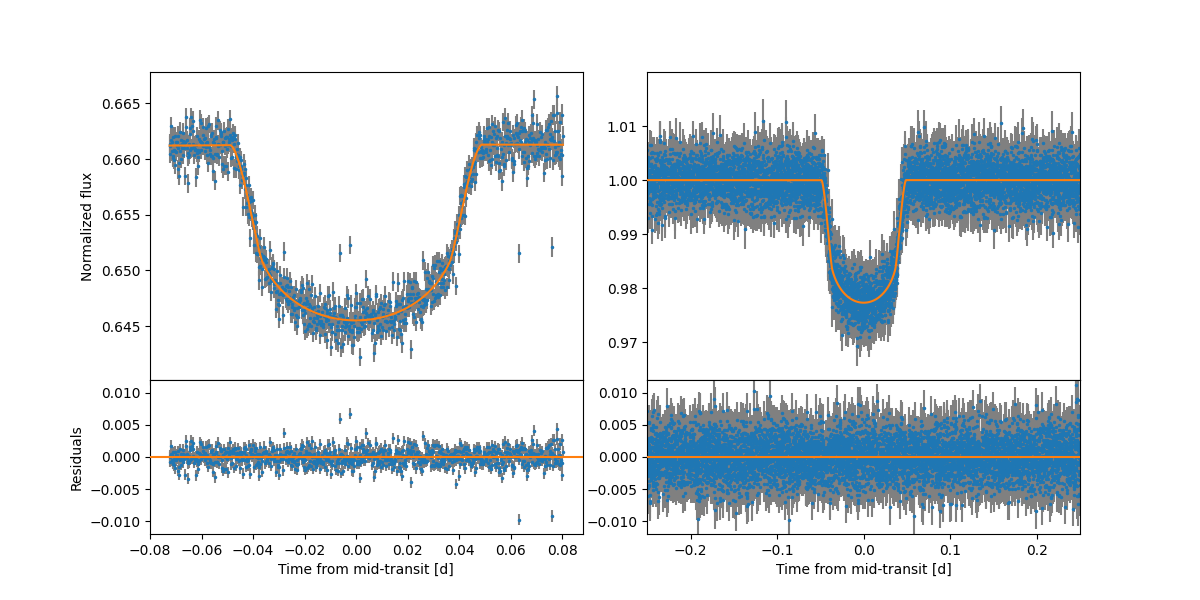

In [42]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

ax0 = plt.subplot(gs[0])
ax0.errorbar(taste_bjd, differential_allref, yerr=differential_allref_err, ecolor='gray', fmt='.', markersize=3)
ax0.plot(taste_bjd, flux_taste_TT, c='C1', zorder=3)
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.set_ylabel('Normalized flux')

ax1 = plt.subplot(gs[1])
ax1.errorbar(folded_tess_time_TT, normalized_tess, yerr=normalized_tess_err, ecolor='gray', fmt='.', markersize=3)

ax1.plot(folded_range_TT, flux_tess_TT, c='C1', zorder=3)
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(gs[2], sharex=ax0)
ax2.errorbar(taste_bjd, differential_allref - flux_taste_TT, yerr=differential_allref_err, ecolor='gray', fmt='.', markersize=3)
ax2.set_ylim(-0.012, 0.012)

ax2.axhline(0, c='C1', zorder=3)
ax2.set_ylabel('Residuals')
ax2.set_xlabel('Time from mid-transit [d]')

residuals_tess = np.linspace(-1.6, 1.6, len(bjd_tdb_tess))
ax3 = plt.subplot(gs[3], sharex=ax1, sharey=ax2)
ax3.errorbar(residuals_tess, normalized_tess - flux_tess_TT_res, yerr=normalized_tess_err, ecolor='gray', fmt='.', markersize=3)
ax3.set_xlim(-0.25, 0.25)

ax3.axhline(0, c='C1', zorder=3)
ax3.set_xlabel('Time from mid-transit [d]')

plt.subplots_adjust(hspace=.0, wspace=.15)
plt.savefig('./Plots/residuals2.png', dpi = 1000)

plt.show()

In [41]:
mean_res_taste_TT = np.mean(differential_allref - flux_taste_TT)
std_res_taste_TT = np.std(differential_allref - flux_taste_TT)

mean_res_tess_all = np.mean(normalized_tess - flux_tess_all_res)
std_res_tess_all = np.std(normalized_tess - flux_tess_all_res)

mean_res_tess_TT = np.mean(normalized_tess - flux_tess_TT_res)
std_res_tess_TT = np.std(normalized_tess - flux_tess_TT_res)

print('Mean residuals TASTE (TT): ', f'{mean_res_taste_TT:.7f}')
print('Mean residuals TESS (all sectors): ', f'{mean_res_tess_all:.8f}')
print('Mean residuals TESS (TT): ', f'{mean_res_tess_TT:.8f}')
print('STD Residuals TASTE (TT) / Errors: ', f'{std_res_taste_TT/np.mean(differential_allref_err):.3f}')
print('STD Residuals TESS (all) / Errors: ', f'{std_res_tess_all/np.mean(normalized_tess_err):.3f}')
print('STD Residuals TESS (TT) / Errors: ', f'{std_res_tess_TT/np.mean(normalized_tess_err):.3f}')
print(std_res_taste_TT)

Mean residuals TASTE (TT):  0.0000047
Mean residuals TESS (all sectors):  -0.00000082
Mean residuals TESS (TT):  -0.00000092
STD Residuals TASTE (TT) / Errors:  0.002
STD Residuals TESS (all) / Errors:  0.897
STD Residuals TESS (TT) / Errors:  0.897
1.3603671889360516e-06
0.12793636437465686 0.3088377832538418


In [26]:
#Correlation

from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [27]:
#TASTE
corr_LD, _ = spearmanr(flat_sample_taste[:, 5], flat_sample_taste[:, 6])
print(f'{corr_LD:.2f}')
corr_coff, _ = spearmanr(flat_sample_taste[:, 7], flat_sample_taste[:, 9])
print(f'{corr_coff:.2f}')
corr_ia, _ = pearsonr(flat_sample_taste[:, 4], flat_sample_taste[:, 3])
print(f'{corr_ia:.2f}')

-0.61
-0.96
0.85


In [28]:
#TESS
corr_LD, _ = spearmanr(flat_sample_tessall[:, 5], flat_sample_tessall[:, 6])
print(f'{corr_LD:.2f}')
corr_ar, _ = spearmanr(flat_sample_tessall[:, 3], flat_sample_tessall[:, 2])
print(f'{corr_ar:.2f}')
corr_ia, _ = pearsonr(flat_sample_tessall[:, 4], flat_sample_tessall[:, 3])
print(f'{corr_ia:.2f}')
corr_ir, _ = pearsonr(flat_sample_tessall[:, 4], flat_sample_tessall[:, 2])
print(f'{corr_ir:.2f}')

-0.66
-0.72
0.94
-0.83


In [29]:
#TASTE TESS(T)
corr_ia, _ = pearsonr(flat_sample_taste_tess[:, 4], flat_sample_taste_tess[:, 3])
print(f'{corr_ia:.2f}')
corr_ir, _ = pearsonr(flat_sample_taste_tess[:, 4], flat_sample_taste_tess[:, 2])
print(f'{corr_ir:.2f}')
corr_LD_taste, _ = spearmanr(flat_sample_taste_tess[:, 7], flat_sample_taste_tess[:, 8])  #TASTE LD coeff
print(f'{corr_LD_taste:.2f}')
corr_LD_tess, _ = spearmanr(flat_sample_taste_tess[:, 5], flat_sample_taste_tess[:, 6])  #TESS LD coeff
print(f'{corr_LD_tess:.2f}')
corr_ar_tastetess, _ = spearmanr(flat_sample_taste_tess[:, 3], flat_sample_taste_tess[:, 2])
print(f'{corr_ar_tastetess:.2f}')
corr_c_tastetess, _ = spearmanr(flat_sample_taste_tess[:, 9], flat_sample_taste_tess[:, 11])
print(f'{corr_c_tastetess:.2f}')

0.94
-0.81
-0.76
-0.71
-0.70
-0.86


In [30]:
taste_tastetess = [mcmc_taste, mcmc_taste_tess]
#np.savetxt('../Results/MCMC_TASTE_TASTE_TESS(T).txt', taste_tastetess, fmt='%.8f', delimiter=' & ', newline=' \\\\\n')

tess = [mcmc_tess_s23, mcmc_tess_s49, mcmc_tess_s50, mcmc_tess_s76, mcmc_tess_all]
#np.savetxt('../Results/MCMC_TESS.txt', tess, fmt='%.8f', delimiter=' & ', newline=' \\\\\n\n')

In [31]:
for i in range(1, 5):
    print(i, compatibility_test(mcmc_taste[i], mcmc_taste_err[i], mcmc_taste_tess[i], mcmc_taste_tess_err[i]))
print(compatibility_test(mcmc_taste[5:10], mcmc_taste_err[5:10], mcmc_taste_tess[7:12], mcmc_taste_tess_err[7:12]))
#print(compatibility_test(mcmc_taste[-1], mcmc_taste_err[-1], mcmc_taste_tess[-1], mcmc_taste_tess_err[-1]))    jitter

1 0.03309070269155067
2 0.39183521611247585
3 0.6570935394696747
4 0.6762586497316848
[0.00825369 0.02801621 0.14496399 0.00661873 0.12205371]


In [32]:
for i in range(1, 7):
    print(i, compatibility_test(mcmc_tess_all[i], mcmc_tess_all_err[i], mcmc_taste_tess[i], mcmc_taste_tess_err[i]))

1 0.02584300621055536
2 0.40440798260082017
3 0.6369712607428156
4 0.5560264306864383
5 0.02493264225958727
6 0.03304908163150965


In [33]:
print('TASTE:', mcmc_taste)
#print('TASTE ERRORS:', mcmc_taste_err)
print('TESS (all):', mcmc_tess_all)
#print('TESS (all) ERRORS:', mcmc_tess_all_err)
print('TESS 23:', mcmc_tess_s23)
print('TESS 49:', mcmc_tess_s49)
print('TESS 50:', mcmc_tess_s50)
print('TESS 76:', mcmc_tess_s76)
print('TASTE+TESS:', mcmc_taste_tess)
#print('TASTE+TESS ERRORS:', mcmc_taste_tess_err)

TASTE: [2.45999064e+06 3.21305729e+00 1.36719719e-01 1.18737402e+01
 8.93852064e+01 6.01555974e-01 1.24864579e-01 6.61247591e-01
 5.11011383e-04 2.10173524e-03 9.71598842e-04 1.16952658e-01
 1.42297863e-04 1.12350686e-03]
TESS (all): [2.45968540e+06 3.21305728e+00 1.38100687e-01 1.14985274e+01
 8.85749693e+01 4.74988315e-01 1.15840152e-01 2.59553320e-05]
TESS 23: [2.45968538e+06 3.21297553e+00 1.38022251e-01 1.13535267e+01
 8.84458764e+01 5.34006445e-01 1.51416696e-01 3.48565311e-05]
TESS 49: [2.45968540e+06 3.21301176e+00 1.37701452e-01 1.18656329e+01
 8.90902258e+01 4.14984316e-01 1.01256512e-01 5.37964107e-05]
TESS 50: [2.45968540e+06 3.21307924e+00 1.37572130e-01 1.14725067e+01
 8.85731925e+01 4.69275205e-01 1.36283435e-01 7.34812147e-05]
TESS 76: [2.45968540e+06 3.21303316e+00 1.37694563e-01 1.13547700e+01
 8.86346509e+01 5.16412201e-01 1.61328035e-01 7.46122201e-05]
TASTE+TESS: [ 2.45968540e+06  3.21305726e+00  1.37437257e-01  1.17087555e+01
  8.89396160e+01  4.76456055e-01  1.19